In [2]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_learning_curves
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
# from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import re
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import validation_curve
from nltk.corpus import words
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from nltk.stem import PorterStemmer
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier

In [3]:
x_train_original = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_train.csv", 
                               index_col = False, delimiter = ',', header=0)

In [4]:
train_label = x_train_original.loc[:,'duration_label']

In [5]:
train_label.value_counts()

2.0    20246
1.0    17705
3.0     2049
Name: duration_label, dtype: int64

### Can try TruncatedSVD, PCA does not support sparse matrices

In [6]:
full_train = x_train_original.drop(columns="duration_label")
full_train_sampled = full_train.copy(deep=True)

In [7]:
full_train['steps'] = full_train['steps'].apply(eval)
full_train['ingredients'] = full_train['ingredients'].apply(eval)
full_train['steps'] = full_train['steps'].apply(' '.join)
full_train['ingredients'] = full_train['ingredients'].apply(' '.join)



In [8]:
full_set = []

for i in range (0, len(full_train['steps'])):
    s = ''
    s += full_train.loc[i,'name'] + full_train.loc[i, 'steps'] + full_train.loc[i, 'ingredients']
    full_set.append(s)

### full_X is the countvec form of the entire original training set! USE THIS FOR ALL GRID SEARCH!
full_X is original training data   
train_label is the original training label   
This is the preprocessing step, selecting 1 gram and 2 gram patterns, as well as removing the bottom 1% of pattern from count vectorizer

In [9]:
# vfull_with_dict = CountVectorizer(stop_words='english', ngram_range=(1,2), strip_accents='unicode', vocabulary=dictionary)
vfull_with_dict = CountVectorizer(stop_words='english', ngram_range=(1,2), strip_accents='unicode', min_df=0.01)
full_vec_dict = vfull_with_dict.fit(full_set)
full_X = vfull_with_dict.transform(full_set)

In [10]:
full_X.shape
# vfull_with_dict.vocabulary_

(40000, 1314)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(full_X,train_label, test_size=0.2, stratify=train_label, random_state=42)


In [12]:
### Implement oversampling
X_train.shape
oversample = RandomOverSampler(sampling_strategy='minority')
# First random oversampling, bring count of class 3 to be equal to the highest class count.
smX, smY = oversample.fit_resample(X_train, y_train)
# Second random oversampling, bring the count of class 2 to be equal to the other 2 classes
smX, smY = oversample.fit_resample(smX, smY)

smX.shape, smY.shape

((48591, 1314), (48591,))

In [12]:
t_svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
truncated_full = t_svd.fit_transform(full_X)

In [13]:
truncated_full.shape
truncated_full = pd.DataFrame(truncated_full)
truncated_full

,0,1
0,5.750174,-4.115362
1,5.533039,-0.038839
2,5.748615,0.081497
3,3.707204,-0.685620
4,1.488678,1.631702
...,...,...
39995,3.482257,2.785053
39996,9.635516,-1.748083
39997,3.932775,-2.558188
39998,6.743969,-2.314970


### Visualising the data with TruncatedSVD
outliers spotted   
No clear cluster for label 3 as expected, could be due to low number of label 3 instances.   
Cluster of 1 is very close to cluster of 2

Clusters are very close, and unclear cluster for label 3. Hence KNN will not be very useful for this dataset.

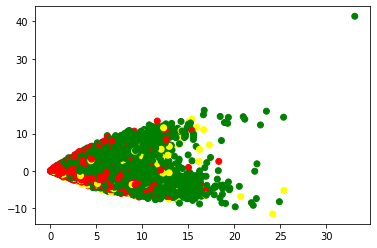

In [14]:
colors = {1:'red', 2:'green', 3:'yellow'}

fig, ax = plt.subplots()
ax.scatter(truncated_full.iloc[:,0], truncated_full.iloc[:,1], c=train_label.map(colors))

### Plot each class label in seperated graph for better visualization

In [15]:
def  color_visualisation(curr_label):
    visual = train_label.copy(deep = True)
    data = truncated_full.copy(deep=True)

    for idex, label in enumerate(visual):
        if (label != curr_label):
            visual = visual.drop(idex, axis="index")
            data = data.drop(idex, axis = "index")

    return visual, data

In [16]:
red_visual, red_data = color_visualisation(1.0)

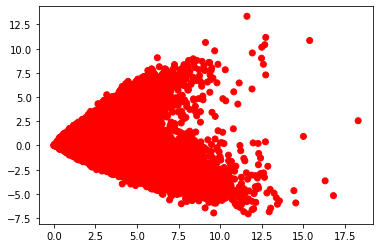

In [17]:
colors = {1:'red', 2:'green', 3:'yellow'}

fig, ax = plt.subplots()
ax.scatter(red_data.iloc[:,0], red_data.iloc[:,1], c=red_visual.map(colors))

In [18]:
green_visual, green_data = color_visualisation(2.0)

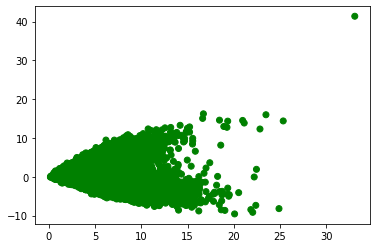

In [19]:
colors = {1:'red', 2:'green', 3:'yellow'}

fig, ax = plt.subplots()
ax.scatter(green_data.iloc[:,0], green_data.iloc[:,1], c=green_visual.map(colors))

In [20]:
yellow_visual, yellow_data = color_visualisation(3.0)

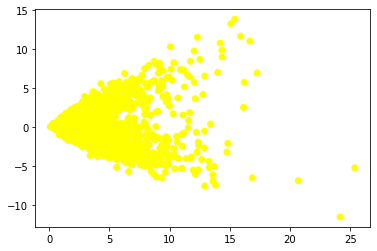

In [21]:
colors = {1:'red', 2:'green', 3:'yellow'}

fig, ax = plt.subplots()
ax.scatter(yellow_data.iloc[:,0], yellow_data.iloc[:,1], c=yellow_visual.map(colors))

### Binarizing class label to calculate cross validation precision,recall and f1

In [13]:
lb = LabelBinarizer()
label_binarized = np.array([number[0] for number in lb.fit_transform(train_label)])


In [14]:
label_binarized

array([0, 0, 0, ..., 1, 0, 0])

### KNN
Terrible as predicted

In [24]:
knn = KNeighborsClassifier(n_neighbors=3)

In [25]:
knn_scores = cross_val_score(knn, truncated_full, train_label, cv=5,n_jobs=-1)
knn_precision = cross_val_score(knn, truncated_full, label_binarized, cv=5, scoring='precision', n_jobs=-1)
knn_recall = cross_val_score(knn, truncated_full, label_binarized, cv=5, scoring='recall', n_jobs=-1)
knn_f1 = cross_val_score(knn, truncated_full, label_binarized, cv=5, scoring='f1', n_jobs=-1)

In [26]:
X_tr, X_te, y_tr, y_te = train_test_split(truncated_full,train_label, test_size=0.2, stratify=train_label, random_state=42)


In [27]:
knn.fit(X_tr, y_tr)

y_pred = knn.predict(X_te)
y_train_pred = knn.predict(X_tr)

print("test:", accuracy_score(y_te, y_pred))
print("train:", accuracy_score(y_tr, y_train_pred))
# print('scoring:', clf.score(X_t, y_test))
print(classification_report(y_te, y_pred))
cm = confusion_matrix(y_te, y_pred)
cm

test: 0.6
train: 0.76115625
              precision    recall  f1-score   support

         1.0       0.57      0.62      0.59      3541
         2.0       0.64      0.64      0.64      4049
         3.0       0.12      0.02      0.04       410

    accuracy                           0.60      8000
   macro avg       0.44      0.43      0.42      8000
weighted avg       0.58      0.60      0.59      8000



array([[2185, 1320,   36],
       [1408, 2605,   36],
       [ 234,  166,   10]], dtype=int64)

In [28]:
print("Accuracy: %0.2f (+/- %0.2f)" % (knn_scores.mean(), knn_scores.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (knn_precision.mean(), knn_precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (knn_recall.mean(), knn_recall.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (knn_f1.mean(), knn_f1.std() * 2))

Accuracy: 0.59 (+/- 0.01)
Precision: 0.57 (+/- 0.01)
Recall: 0.54 (+/- 0.02)
F1: 0.56 (+/- 0.01)


### Logistic Regression
current best: Logclf = LogisticRegression(C=0.008, max_iter=5000, random_state=0, solver=saga)
Recommended by gridsearchCV: {'C': 0.1}

In [112]:
Logclf = LogisticRegression(C=0.1, max_iter=5000, random_state=0, solver='saga')
clf = make_pipeline(MaxAbsScaler(),Logclf)

In [30]:
logclf_scores = cross_val_score(clf, full_X, train_label, cv=5,n_jobs=-1)
logclf_precision = cross_val_score(clf, full_X, label_binarized, cv=5, scoring='precision', n_jobs=-1)
logclf_recall = cross_val_score(clf, full_X, label_binarized, cv=5, scoring='recall', n_jobs=-1)
logclf_f1 = cross_val_score(clf, full_X, label_binarized, cv=5, scoring='f1', n_jobs=-1)

In [113]:
clf.fit(smX, smY)

y_pred = clf.predict(X_test)
y_train_pred = clf.predict(smX)

print("test:", accuracy_score(y_test, y_pred))
print("train:", accuracy_score(smY, y_train_pred))
# print('scoring:', clf.score(X_t, y_test))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm

test: 0.77925
train: 0.8401761643102632
              precision    recall  f1-score   support

         1.0       0.76      0.83      0.79      3541
         2.0       0.86      0.74      0.79      4049
         3.0       0.48      0.80      0.59       410

    accuracy                           0.78      8000
   macro avg       0.70      0.79      0.73      8000
weighted avg       0.80      0.78      0.78      8000



array([[2923,  458,  160],
       [ 864, 2985,  200],
       [  44,   40,  326]], dtype=int64)

### Cross-validation result

In [32]:
print("Accuracy: %0.2f (+/- %0.2f)" % (logclf_scores.mean(), logclf_scores.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (logclf_precision.mean(), logclf_precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (logclf_recall.mean(), logclf_recall.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (logclf_f1.mean(), logclf_f1.std() * 2))

Accuracy: 0.80 (+/- 0.01)
Precision: 0.78 (+/- 0.01)
Recall: 0.82 (+/- 0.02)
F1: 0.80 (+/- 0.01)


### Logistic Regression Learning Curve

In [ ]:
param_range = np.logspace(-10, 2, 100)
LSVC = make_pipeline(MaxAbsScaler(), LogisticRegression(max_iter=5000, random_state=0, solver='saga'))
train_scores, validation_scores = validation_curve(LSVC, full_X, train_label, param_name='logisticregression__C',
                                                   param_range=param_range, cv=5, n_jobs=-1, verbose=-1)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 500 | elapsed:  1.2min remaining: 309.5min


In [ ]:
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_valid_scores = np.mean(validation_scores, axis=1)
std_valid_scores = np.std(validation_scores, axis =1)

In [ ]:
plt.semilogx(param_range, mean_train_scores, label="training score", color = 'r')
plt.fill_between(param_range, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2, color='r')
plt.semilogx(param_range, mean_valid_scores, label="cross validation score", color = 'b')
plt.fill_between(param_range, mean_valid_scores - std_valid_scores, mean_valid_scores + std_valid_scores, alpha=0.2, color='b')
plt.legend(loc="best")
plt.title("validation curve for hyperparameter C in LinearSVC")
plt.xlabel("C in log scale")
plt.ylabel("Accuracy")
plt.show()

### Logistic Regression Hyperparameter tuning and CV result
This uses the full training set   

Output of box below:   
Fitting 5 folds for each of 12 candidates, totalling 60 fits   
0.8764586400809865   
{'C': 0.1}

In [ ]:
param_LogReg = {
    # Comparing previous gridCV best of 0.1 to what we found to be best. 0.1 is still better on the training set.
    'C': np.logspace(-10, 2, 100)
}

X_scaled = MaxAbsScaler().fit_transform(full_X)
gridCV = GridSearchCV(Logclf, param_LogReg, n_jobs=-1)

gridCV.fit(X_scaled, train_label)
# gridCV.best_params_
print(gridCV.best_score_)
print(gridCV.best_params_)

In [154]:
print("current acc:", accuracy_score(y_test, pred))

current acc: 0.78625


### LinearSVC
best C: 0.005 or 0.053366992312063016
GRIDCV best C: 0.5

In [33]:
LinearSVC_clf = svm.LinearSVC(C=0.5,dual=False, multi_class='ovr',random_state=0)
SVC_clf = make_pipeline(MaxAbsScaler(), LinearSVC_clf)

In [34]:
LinearSVC_scores = cross_val_score(SVC_clf, full_X, train_label, cv=5, n_jobs=-1)
LinearSVC_precision = cross_val_score(SVC_clf, full_X, label_binarized, cv=5, scoring='precision', n_jobs=-1)
LinearSVC_recall = cross_val_score(SVC_clf, full_X, label_binarized, cv=5, scoring='recall', n_jobs=-1)
LinearSVC_f1 = cross_val_score(SVC_clf, full_X, label_binarized, cv=5, scoring='f1', n_jobs=-1)

In [35]:
SVC_clf.fit(smX, smY)

y_test_predict = SVC_clf.predict(X_test)
y_train_predict = SVC_clf.predict(smX)
print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(smY, y_train_predict))
print(classification_report(y_test, y_test_predict))
cm = confusion_matrix(y_test, y_test_predict)
cm

0.772125
0.8539235660924862
              precision    recall  f1-score   support

         1.0       0.76      0.81      0.78      3541
         2.0       0.85      0.74      0.79      4049
         3.0       0.47      0.78      0.58       410

    accuracy                           0.77      8000
   macro avg       0.69      0.78      0.72      8000
weighted avg       0.79      0.77      0.78      8000



array([[2869,  504,  168],
       [ 861, 2988,  200],
       [  49,   41,  320]], dtype=int64)

### Cross Validation Result

In [36]:
print("Accuracy: %0.2f (+/- %0.2f)" % (LinearSVC_scores.mean(), LinearSVC_scores.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (LinearSVC_precision.mean(), LinearSVC_precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (LinearSVC_recall.mean(), LinearSVC_recall.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (LinearSVC_f1.mean(), LinearSVC_f1.std() * 2))

Accuracy: 0.80 (+/- 0.01)
Precision: 0.77 (+/- 0.01)
Recall: 0.83 (+/- 0.02)
F1: 0.80 (+/- 0.01)


### LinearSVC Learning Curve

In [82]:
param_range = np.logspace(-10, 2, 100)
LSVC = make_pipeline(MaxAbsScaler(), svm.LinearSVC(random_state=0))
train_scores, validation_scores = validation_curve(LSVC, full_X, train_label, param_name='linearsvc__C',
                                                   param_range=param_range, cv=5, n_jobs=-1, verbose=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 500 | elapsed:    2.4s remaining: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.6min finished


In [83]:
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_valid_scores = np.mean(validation_scores, axis=1)
std_valid_scores = np.std(validation_scores, axis =1)

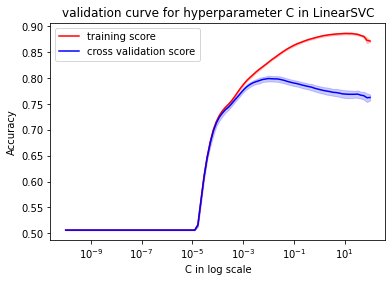

In [84]:
plt.semilogx(param_range, mean_train_scores, label="training score", color = 'r')
plt.fill_between(param_range, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2, color='r')
plt.semilogx(param_range, mean_valid_scores, label="cross validation score", color = 'b')
plt.fill_between(param_range, mean_valid_scores - std_valid_scores, mean_valid_scores + std_valid_scores, alpha=0.2, color='b')
plt.legend(loc="best")
plt.title("validation curve for hyperparameter C in LinearSVC")
plt.xlabel("C in log scale")
plt.ylabel("Accuracy")
plt.show()

### LinearSVC HyperParameter tuning

GridsearchCV on C parameter shows {'C': 0.053366992312063016}   
Best score (Mean cross-validated score of the best_estimator): 0.8593566754087872

In [67]:
# Grid search
parameters = {'C': np.logspace(-10, 2, 100)}


svc = svm.LinearSVC(dual=False, multi_class='ovr',random_state=0)

# X_scaled = MaxAbsScaler().fit_transform(X)
X_scaled = MaxAbsScaler().fit_transform(full_X)
gridCV = GridSearchCV(svc, parameters, n_jobs=-1)

gridCV.fit(X_scaled, train_label)
print(gridCV.best_score_)
print(gridCV.best_params_)

{'C': 0.053366992312063016}

In [156]:
cv_result = pd.DataFrame(gridCV.cv_results_)
cv_result
graph_df = cv_result.loc[:,['param_C','mean_test_score']]
graph_df

,param_C,mean_test_score
0,0.0,0.588751
1,0.0,0.588751
2,0.0,0.588751
3,0.0,0.588751
4,0.0,0.588751
...,...,...
95,32.745492,0.838715
96,43.287613,0.838221
97,57.223677,0.838283
98,75.646333,0.837830


In [ ]:

plt.plot(graph_df.iloc[:,0], graph_df.iloc[:,1])
plt.xlabel('param_C')
plt.ylabel('mean_test_score')
# plt.legend()
plt.show()

### SGD Classifier

In [15]:
clf_SGD = SGDClassifier(alpha=0.001,max_iter=1000, tol=1e-3, n_jobs=6, random_state=0)
SGD = make_pipeline(MaxAbsScaler(),clf_SGD)

In [16]:
SGD_scores = cross_val_score(SGD, full_X, train_label, cv=5, n_jobs=-1)
SGD_precision = cross_val_score(SGD, full_X, label_binarized, cv=5, scoring='precision', n_jobs=-1)
SGD_recall = cross_val_score(SGD, full_X, label_binarized, cv=5, scoring='recall', n_jobs=-1)
SGD_f1 = cross_val_score(SGD, full_X, label_binarized, cv=5, scoring='f1', n_jobs=-1)

### Oversampling with train test split

In [39]:
SGD.fit(smX, smY)

y_test_predict_SGD = SGD.predict(X_test)
y_train_predict_SGD = SGD.predict(smX)
print(accuracy_score(y_test, y_test_predict_SGD))
print(accuracy_score(smY, y_train_predict_SGD))


print(classification_report(y_test, y_test_predict_SGD))
cm = confusion_matrix(y_test, y_test_predict_SGD)
cm

0.76625
0.8189582432960837
              precision    recall  f1-score   support

         1.0       0.75      0.83      0.79      3541
         2.0       0.87      0.70      0.78      4049
         3.0       0.43      0.84      0.57       410

    accuracy                           0.77      8000
   macro avg       0.68      0.79      0.71      8000
weighted avg       0.79      0.77      0.77      8000



array([[2939,  397,  205],
       [ 953, 2848,  248],
       [  39,   28,  343]], dtype=int64)

### Cross Validation result

In [40]:
print("Accuracy: %0.2f (+/- %0.2f)" % (SGD_scores.mean(), SGD_scores.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (SGD_precision.mean(), SGD_precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (SGD_recall.mean(), SGD_recall.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (SGD_f1.mean(), SGD_f1.std() * 2))

Accuracy: 0.80 (+/- 0.01)
Precision: 0.77 (+/- 0.01)
Recall: 0.83 (+/- 0.02)
F1: 0.80 (+/- 0.01)


### SGD Classifier Learning Curve

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 500 | elapsed:    1.4s remaining:  6.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.6min finished


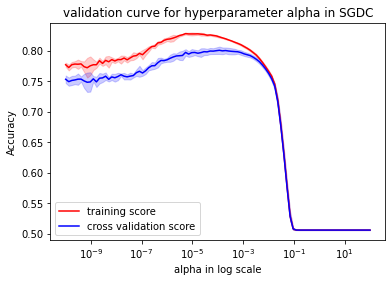

In [20]:
param_range = np.logspace(-10, 2, 100)
train_scores, validation_scores = validation_curve(SGD, full_X, train_label, param_name='sgdclassifier__alpha',
                                                   param_range=param_range, cv=5, n_jobs=-1, verbose=-1)



mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_valid_scores = np.mean(validation_scores, axis=1)
std_valid_scores = np.std(validation_scores, axis =1)


plt.semilogx(param_range, mean_train_scores, label="training score", color = 'r')
plt.fill_between(param_range, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2, color='r')
plt.semilogx(param_range, mean_valid_scores, label="cross validation score", color = 'b')
plt.fill_between(param_range, mean_valid_scores - std_valid_scores, mean_valid_scores + std_valid_scores, alpha=0.2, color='b')
plt.legend(loc="best")
plt.title("validation curve for hyperparameter alpha in SGDC")
plt.xlabel("alpha in log scale")
plt.ylabel("Accuracy")
plt.show()

### SGD Classifier HyperParameter Tuning

In [ ]:
pipeline = Pipeline(
[
      ('clf', clf_SGD)
])
parameters ={
    'clf__loss':('hinge', 'log'), #hinge loss : linearsvc; log loss: logistic regression
    'clf__alpha':(1e-5, 1e-4, 1e-3, 1e-2), #regalarisation/penulty, similar to C in linearSVC
}
from time import time
def grid_search(pipeline, parameters, X, y):
    gs = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
    print("Performing grid search")
    print("pipeline", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    gs.fit(X, y)
    print("done in %0.3fs" %(time() - t0))
    
    # print out best 5 results
    mean_score = gs.cv_results_['mean_test_score']
    param_set = gs.cv_results_['params']
    for idx in mean_score.argsort()[-5:]:
        print(param_set[idx])
        print(gs.cv_results_['mean_test_score'][idx])
        print("="*30)
    return gs
results = grid_search(pipeline, parameters, X, y_oversampled)
results

### Random Forest

In [61]:
forest = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=10, 
                                criterion='gini', n_jobs = -1, random_state = 0)

In [42]:
forest_scores = cross_val_score(forest, full_X, train_label, cv=5, n_jobs=-1)
forest_precision = cross_val_score(forest, full_X, label_binarized, cv=5, scoring='precision', n_jobs=-1)
forest_recall = cross_val_score(forest, full_X, label_binarized, cv=5, scoring='recall', n_jobs=-1)
forest_f1 = cross_val_score(forest, full_X, label_binarized, cv=5, scoring='f1', n_jobs=-1)

In [62]:
forest.fit(smX, smY)

y_test_predict = forest.predict(X_test)
y_train_predict = forest.predict(smX)
print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(smY, y_train_predict))


print(classification_report(y_test, y_test_predict))
cm = confusion_matrix(y_test, y_test_predict)
cm

0.753625
0.8141013767981725
              precision    recall  f1-score   support

         1.0       0.73      0.78      0.75      3541
         2.0       0.81      0.73      0.77      4049
         3.0       0.54      0.76      0.63       410

    accuracy                           0.75      8000
   macro avg       0.69      0.76      0.72      8000
weighted avg       0.76      0.75      0.76      8000



array([[2755,  648,  138],
       [ 957, 2961,  131],
       [  52,   45,  313]], dtype=int64)

### Cross-validation Result

In [43]:
print("Accuracy: %0.2f (+/- %0.2f)" % (forest_scores.mean(), forest_scores.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (forest_precision.mean(), forest_precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (forest_recall.mean(), forest_recall.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (forest_f1.mean(), forest_f1.std() * 2))

Accuracy: 0.77 (+/- 0.01)
Precision: 0.79 (+/- 0.01)
Recall: 0.73 (+/- 0.02)
F1: 0.76 (+/- 0.01)


### Random Forest Hyperparameter Tuning

Exhaustive grid search gives:
{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 100}   
     
     
CV_rfc.best_score_ = 0.685825

In [24]:
# Grid search
param_grid = { 
    'n_estimators': [100,200, 300, 400, 500, 1000, 1500, 2000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10],
    'criterion' :['gini', 'entropy']
}
forest2 = RandomForestClassifier(random_state=0)
# CV_rfc = RandomizedSearchCV(estimator=forest, param_distributions =param_grid, n_iter=10, cv= 4, random_state=0, n_jobs = -1)
CV_rfc = GridSearchCV(estimator=forest2, param_grid=param_grid, n_jobs=-1)
CV_rfc.fit(full_X,train_label)
CV_rfc.best_params_


{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 100}

In [30]:
forestGCV = pd.DataFrame(CV_rfc.cv_results_)
forestGCV

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.272598,0.030057,1.730800,0.174086,gini,1,auto,100,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.50625,0.506125,0.506125,0.506125,0.506125,0.50615,0.00005,249
1,6.222998,0.043913,3.437001,0.176919,gini,1,auto,200,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.50625,0.506125,0.506125,0.506125,0.506125,0.50615,0.00005,249
2,9.312998,0.235289,6.454201,0.596819,gini,1,auto,300,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.50625,0.506125,0.506125,0.506125,0.506125,0.50615,0.00005,249
3,12.335400,0.186783,9.710199,0.416473,gini,1,auto,400,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.50625,0.506125,0.506125,0.506125,0.506125,0.50615,0.00005,249
4,15.496395,0.218124,10.041801,0.688904,gini,1,auto,500,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.50625,0.506125,0.506125,0.506125,0.506125,0.50615,0.00005,249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,11.841400,0.190456,3.592000,0.444654,entropy,10,log2,400,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.50625,0.506125,0.506125,0.506125,0.506125,0.50615,0.00005,249
476,14.822400,0.212913,4.530400,0.597575,entropy,10,log2,500,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.50625,0.506125,0.506125,0.506125,0.506125,0.50615,0.00005,249
477,29.366000,0.323715,10.195800,0.798592,entropy,10,log2,1000,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.50625,0.506125,0.506125,0.506125,0.506125,0.50615,0.00005,249
478,45.167001,0.587821,17.866199,2.896989,entropy,10,log2,1500,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.50625,0.506125,0.506125,0.506125,0.506125,0.50615,0.00005,249


### Random Forest Learning Curve

In [148]:
test_y = []
train_y = []

for depth in range(1,11):
    forest = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=depth, 
                                criterion='gini', n_jobs = -1, random_state = 0)
    
    forest.fit(X, y_oversampled)
    Forest_pred = forest.predict(X_t)
    Forest_train_pred = forest.predict(X)
    
    test_y.append(accuracy_score(y_test, Forest_pred))
    train_y.append(accuracy_score(y_oversampled, Forest_train_pred))
    

acc = {
    'test_y': test_y,
    'train_y': train_y
}


acc_df = pd.DataFrame(acc, columns = ['test_y','train_y'])
acc_df

,test_y,train_y
0,0.637000,0.654895
1,0.663125,0.676113
2,0.675250,0.692248
3,0.686250,0.704678
4,0.692250,0.712786
5,0.706500,0.732440
6,0.720875,0.743883
7,0.721875,0.757383
8,0.735375,0.772674
9,0.734000,0.781606


In [150]:
X.shape

(48591, 9841)

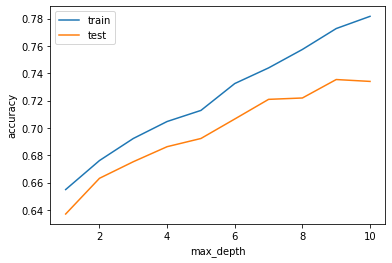

In [149]:
depth = [1,2,3,4,5,6,7,8,9,10]

plt.plot(depth, train_y, label = "train")
plt.plot(depth, test_y, label = "test")
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [164]:
param_range = [1,2,3,4,5,6,7,8,9,10]
RD = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=10, 
                                criterion='gini', n_jobs = -1, random_state = 0)
RD_train_scores, RD_validation_scores = validation_curve(RD, full_X, train_label, param_name='max_depth',
                                                   param_range=param_range, cv=5, n_jobs=-1, verbose=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  50 | elapsed:    2.4s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.0s finished


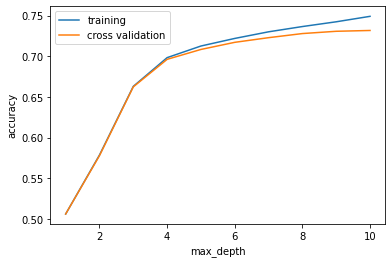

In [196]:
# plt.plot(param_range, RD_train_scores.ravel(), label = "train")
# plt.plot(param_range, RD_validation_scores.ravel(), label = "test")
# plt.xlabel('max_depth')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show()

RD_validation_scores.ravel().shape, RD_train_scores.ravel().shape


validation = []
training=[]

for val in RD_validation_scores:
    validation.append(np.mean(val))
    
for train in RD_train_scores:
    training.append(np.mean(train))
    
    
    
plt.plot(param_range, training, label = "training")
plt.plot(param_range, validation, label = "cross validation")
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()


### Boosting

In [44]:
Adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,random_state=0), n_estimators=100, random_state=0)
Adaboost.fit(smX, smY)

y_test_predict = Adaboost.predict(X_test)
y_train_predict = Adaboost.predict(smX)
print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(smY, y_train_predict))


print(classification_report(y_test, y_test_predict))
cm = confusion_matrix(y_test, y_test_predict)
cm

0.7445
0.7808853491387294
              precision    recall  f1-score   support

         1.0       0.74      0.76      0.75      3541
         2.0       0.80      0.73      0.76      4049
         3.0       0.48      0.81      0.60       410

    accuracy                           0.74      8000
   macro avg       0.67      0.77      0.70      8000
weighted avg       0.76      0.74      0.75      8000



array([[2687,  686,  168],
       [ 919, 2936,  194],
       [  45,   32,  333]], dtype=int64)

In [45]:
Adaboost_scores = cross_val_score(Adaboost, full_X, train_label, cv=5, n_jobs=-1)
Adaboost_precision = cross_val_score(Adaboost, full_X, label_binarized, cv=5, scoring='precision', n_jobs=-1)
Adaboost_recall = cross_val_score(Adaboost, full_X, label_binarized, cv=5, scoring='recall', n_jobs=-1)
Adaboost_f1 = cross_val_score(Adaboost, full_X, label_binarized, cv=5, scoring='f1', n_jobs=-1)

In [46]:
print("Accuracy: %0.2f (+/- %0.2f)" % (Adaboost_scores.mean(), Adaboost_scores.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (Adaboost_precision.mean(), Adaboost_precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (Adaboost_recall.mean(), Adaboost_recall.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (Adaboost_f1.mean(), Adaboost_f1.std() * 2))

Accuracy: 0.76 (+/- 0.01)
Precision: 0.77 (+/- 0.01)
Recall: 0.81 (+/- 0.02)
F1: 0.79 (+/- 0.01)


### Stacking Classifier

In [89]:
estimators = [
     ('LinearSVC', SVC_clf),
        ('RandomForest', forest),
     ('SGD', SGD),
# #     ('KNN', knn)]
    ('LogisticRegression', clf)
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=make_pipeline(MaxAbsScaler(), LogisticRegression(n_jobs=-1, max_iter=5000,random_state=0)), n_jobs=-1)


### Stacking evaluation

In [90]:
stacking_clf.fit(smX, smY)
y_test_predict = stacking_clf.predict(X_test)
y_train_predict = stacking_clf.predict(smX)
print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(smY, y_train_predict))


print(classification_report(y_test, y_test_predict))
cm = confusion_matrix(y_test, y_test_predict)
cm

0.786125
0.8607355271552345
              precision    recall  f1-score   support

         1.0       0.77      0.81      0.79      3541
         2.0       0.84      0.77      0.80      4049
         3.0       0.53      0.75      0.62       410

    accuracy                           0.79      8000
   macro avg       0.71      0.78      0.74      8000
weighted avg       0.79      0.79      0.79      8000



array([[2878,  508,  155],
       [ 828, 3104,  117],
       [  38,   65,  307]], dtype=int64)

In [84]:
stacking_clf_scores = cross_val_score(stacking_clf, full_X, train_label, cv=5, n_jobs=-1)
stacking_clf_precision = cross_val_score(stacking_clf, full_X, label_binarized, cv=5, scoring='precision', n_jobs=-1)
stacking_clf_recall = cross_val_score(stacking_clf, full_X, label_binarized, cv=5, scoring='recall', n_jobs=-1)
stacking_clf_f1 = cross_val_score(stacking_clf, full_X, label_binarized, cv=5, scoring='f1', n_jobs=-1)

In [85]:
print("Accuracy: %0.2f (+/- %0.2f)" % (stacking_clf_scores.mean(), stacking_clf_scores.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (stacking_clf_precision.mean(), stacking_clf_precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (stacking_clf_recall.mean(), stacking_clf_recall.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (stacking_clf_f1.mean(), stacking_clf_f1.std() * 2))

Accuracy: 0.80 (+/- 0.01)
Precision: 0.78 (+/- 0.01)
Recall: 0.81 (+/- 0.02)
F1: 0.80 (+/- 0.01)


### Base Line Model

In [97]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(smX, smY)

y_test_predict = dummy_clf.predict(X_test)
y_train_predict = dummy_clf.predict(smX)
print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(smY, y_train_predict))
print(classification_report(y_test, y_test_predict))
cm = confusion_matrix(y_test, y_test_predict)
cm

0.442625
0.3333333333333333
              precision    recall  f1-score   support

         1.0       0.44      1.00      0.61      3541
         2.0       0.00      0.00      0.00      4049
         3.0       0.00      0.00      0.00       410

    accuracy                           0.44      8000
   macro avg       0.15      0.33      0.20      8000
weighted avg       0.20      0.44      0.27      8000



c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

array([[3541,    0,    0],
       [4049,    0,    0],
       [ 410,    0,    0]], dtype=int64)

In [98]:
dummy_clf_scores = cross_val_score(dummy_clf, full_X, train_label, cv=5, n_jobs=-1)
dummy_clf_scores_precision = cross_val_score(dummy_clf, full_X, label_binarized, cv=5, scoring='precision', n_jobs=-1)
dummy_clf_scores_recall = cross_val_score(dummy_clf, full_X, label_binarized, cv=5, scoring='recall', n_jobs=-1)
dummy_clf_scores_f1 = cross_val_score(dummy_clf, full_X, label_binarized, cv=5, scoring='f1', n_jobs=-1)

print("Accuracy: %0.2f (+/- %0.2f)" % (dummy_clf_scores.mean(), dummy_clf_scores.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (dummy_clf_scores_precision.mean(), dummy_clf_scores_precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (dummy_clf_scores_recall.mean(), dummy_clf_scores_recall.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (dummy_clf_scores_f1.mean(), dummy_clf_scores_f1.std() * 2))

Accuracy: 0.51 (+/- 0.00)
Precision: 0.00 (+/- 0.00)
Recall: 0.00 (+/- 0.00)
F1: 0.00 (+/- 0.00)


### Testing on Real Test data

In [52]:
x_test_original = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_test.csv", 
                               index_col = False, delimiter = ',', header=0)
x_test_original
x_test_original['steps'] = x_test_original['steps'].apply(eval)
x_test_original['ingredients'] = x_test_original['ingredients'].apply(eval)
x_test_original['steps'] = x_test_original['steps'].apply(' '.join)
x_test_original['ingredients'] = x_test_original['ingredients'].apply(' '.join)
x_test_original

,name,n_steps,n_ingredients,steps,ingredients
0,fantastic chicken curry,9,13,"mix flour , salt and pepper together on a shal...",flour salt black pepper skinless chicken breas...
1,feta with honey,3,3,with a mortar and pestle or with the bottom of...,black peppercorns feta cheese honey
2,chocolate brownie bites,8,11,preheat oven to 350f line mini muffin cups wit...,butter semi-sweet chocolate chips cocoa powder...
3,flourless banana bread pancakes,9,6,"in a small bowl , peel , break , and then mash...",banana eggs vanilla extract walnuts cooking sp...
4,roasted chicken a la orange,9,10,clean chicken and pat dry sprinkle salt and pe...,roasting chickens sweet onion parsley butter o...
...,...,...,...,...,...
9995,christmas green bean casserole,6,10,prepare green beans in microwave until tender ...,cream of mushroom soup milk soy sauce pepper o...
9996,chestnuts and prunes,6,9,"melt butter in large skillet add chestnuts , s...",chestnuts butter salt and pepper ground fennel...
9997,super simple tropical dressing,2,6,combine all ingredients and chill shake well b...,pineapple juice red wine vinegar olive oil pep...
9998,vegetarian black bean cakes w chunky salsa so...,10,11,put the rinsed beans into a large bowl and mas...,black beans egg white green onions fresh cilan...


In [53]:
test_bag = []

for i in range (0, len(x_test_original['steps'])):
    s = ''
    s += x_test_original.loc[i,'name'] + x_test_original.loc[i, 'steps'] + x_test_original.loc[i, 'ingredients']
    test_bag.append(s)

test_bag

['fantastic chicken currymix flour , salt and pepper together on a shallow plate dredge chicken in flour and shake off excess heat oil in a large skillet and add chicken , browning on both sides remove to a plate add the onion , bell pepper , and garlic to the pan and cook until onion is tender , about 5 minutes add curry powder , coating onions , etc then add potatoes , broth , chutney , to the skillet bring it all to a boil , add the chicken , then reduce heat , cover , and simmer cooking until chicken is cooked through and potatoes are tender , about 20-22 minutes garnish with cilantro , and serve with rice , if desiredflour salt black pepper skinless chicken breasts oil onion green bell pepper garlic mild curry powder potatoes fat-free chicken broth mango chutney fresh cilantro',
 'feta with honeywith a mortar and pestle or with the bottom of a heavy skillet , coarsely crack peppercorns pat feta dry and put on a platter in a measuring cup stir together pepper and honey and pour ove

In [69]:
t = vfull_with_dict.transform(test_bag)
t.shape

(10000, 1314)

### Stacking

In [79]:
final = stacking_clf.predict(t)
final

array([2., 1., 1., ..., 1., 1., 2.])

In [80]:
a = [x for x in range(1,10001)]

result = {
    'id': a,
    'duration_label': final
}
result = pd.DataFrame(result)
result.to_csv('result_LSVC_RD.csv', index = False)
result.loc[:,'duration_label'].value_counts()

1.0    4670
2.0    4526
3.0     804
Name: duration_label, dtype: int64

### LogisticRegression Result

In [57]:

final_logistic = clf.predict(t)
final_logistic


a = [x for x in range(1,10001)]

result = {
    'id': a,
    'duration_label': final_logistic
}
result = pd.DataFrame(result)
result.to_csv('result_logistic.csv', index = False)
result.loc[:,'duration_label'].value_counts()

1.0    4776
2.0    4321
3.0     903
Name: duration_label, dtype: int64

### LinearSVC Result

In [58]:

final_Linear = SVC_clf.predict(t)
final_Linear


a = [x for x in range(1,10001)]

result = {
    'id': a,
    'duration_label': final_Linear
}
result = pd.DataFrame(result)
result.to_csv('result_LinearSVC.csv', index = False)
result.loc[:,'duration_label'].value_counts()

1.0    4721
2.0    4377
3.0     902
Name: duration_label, dtype: int64

### SGD Result

In [59]:

final_Linear = SGD.predict(t)
final_Linear


a = [x for x in range(1,10001)]

result = {
    'id': a,
    'duration_label': final_Linear
}
result = pd.DataFrame(result)
result.to_csv('result_SGD.csv', index = False)
result.loc[:,'duration_label'].value_counts()

1.0    4911
2.0    4043
3.0    1046
Name: duration_label, dtype: int64

### Random Forest result

In [63]:
final_forest = forest.predict(t)
final_forest


a = [x for x in range(1,10001)]

result = {
    'id': a,
    'duration_label': final_forest
}
result = pd.DataFrame(result)
result.to_csv('result_RandomForest.csv', index = False)
result.loc[:,'duration_label'].value_counts()

1.0    4618
2.0    4595
3.0     787
Name: duration_label, dtype: int64

### Adaboost Result

In [64]:
final_Adaboost = Adaboost.predict(t)
final_Adaboost


a = [x for x in range(1,10001)]

result = {
    'id': a,
    'duration_label': final_Adaboost
}
result = pd.DataFrame(result)
result.to_csv('result_Adaboost.csv', index = False)
result.loc[:,'duration_label'].value_counts()

2.0    4558
1.0    4529
3.0     913
Name: duration_label, dtype: int64